In [1]:
import torch
import scipy
from scipy import ndimage
import matplotlib.pyplot as plt
%matplotlib inline

import torch,torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np

from torchvision.datasets import MNIST
import torchvision.transforms as transforms

In [2]:
class Flatten(nn.Module):
    def forward(self,x):
        return x.view(x.size(0),-1)
    
class Empty(nn.Module):
    def forward(self,x):
        return x
    
def get_convnet(nonlinearity,dropout = 0,device = torch.device("cpu")):
    convnet = nn.Sequential(nn.Conv2d(1,6,5),
                            nonlinearity,
                            nn.MaxPool2d(2),
                            nn.Conv2d(6,16,5),
                            nonlinearity,
                            nn.MaxPool2d(2),
                            Flatten(),
                            nn.Linear(400,120),
                            nonlinearity,
                            nn.Linear(120,84),
                            nonlinearity,
                            nn.Dropout(dropout),
                            nn.Linear(84,10))
    return convnet.to(device)

def train_convnet(network,X,Y,num_iters = 1e6,threshold = 1e-3,device = torch.device("cpu")):
    network.train()
    X = Variable(torch.FloatTensor(X)).to(device)
    Y = Variable(torch.LongTensor(Y)).to(device)
    opt = torch.optim.SGD(network.parameters(),lr = 0.01,weight_decay=1e-4,momentum=0.9)
    NLLLoss = nn.modules.loss.NLLLoss()
    history = []
    for iter in range(num_iters):
        Y_logp = F.log_softmax(network(X),dim = -1)
        loss = NLLLoss(Y_logp,Y)
        history.append(loss.data.cpu().numpy())
        if iter > 0 and history[-1] - history[-2]>threshold:
            break
        opt.zero_grad()
        loss.backward()
        opt.step()
    network.eval()
    return network,history



def get_minst_data():
    trans = transforms.Compose([transforms.Pad(2),transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
    mnist = MNIST('MNIST',download=True,transform=trans)

    data_loader = torch.utils.data.DataLoader(mnist,
                                              batch_size=60000,
                                              shuffle=True)
    imags, labels = data_loader.__iter__().__next__()
    return imags, labels

In [3]:
convnet = torch.load('convnet.p', map_location='cpu')
imags, labels = get_minst_data()

CPU times: user 6.57 s, sys: 488 ms, total: 7.06 s
Wall time: 6.53 s


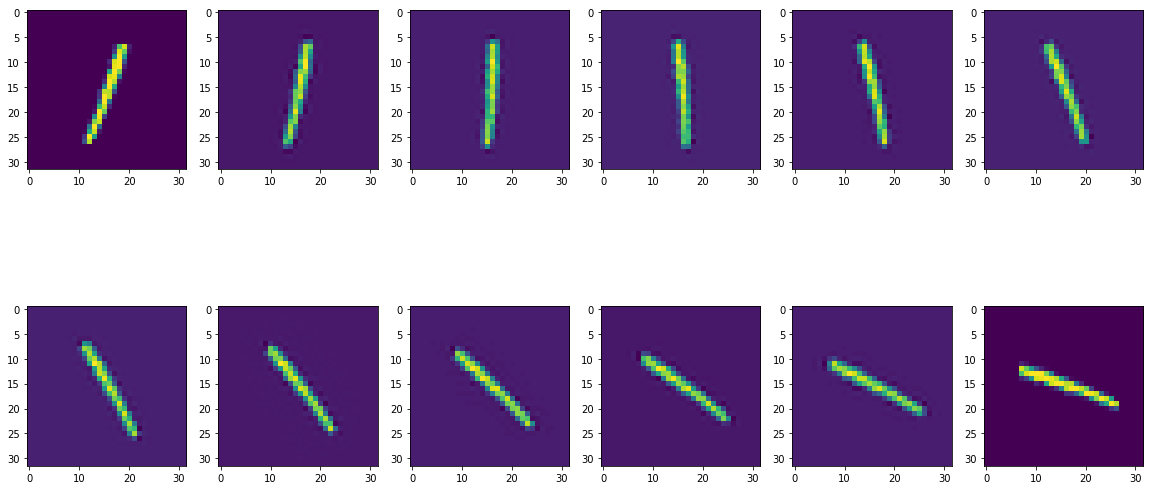

In [4]:
%%time

plt.figure(figsize=(20, 10))
convnet.train()
IMAGE = imags[int((labels==1).sort()[1][-6])] # choose image of 1

SIZE = 1000
angles = np.linspace(0, 90, 12)

data_probas = np.zeros((10, len(angles), SIZE))
data_output = np.zeros((10, len(angles), SIZE))

for i_angle, angle in enumerate(angles):
    
    image = IMAGE.data.numpy()
    image = ndimage.interpolation.rotate(image[0], angle, reshape=False, cval=-0.5)
    plt.subplot(2, 6, i_angle + 1)
    plt.imshow(image)
    image = torch.unsqueeze(torch.unsqueeze(torch.tensor(image), 0), 0)
    
    for num_experiment in range(SIZE):
        output = convnet(image)
        
        sorted_output, rate = output.sort()
        sorted_output = sorted_output.data.numpy()[0]
        rate = rate.data.numpy()[0]
        
        proba, val = F.softmax(output, dim=-1).sort()
        proba = proba.data.numpy()[0]
        val = val.data.numpy()[0]
        
        for i in range(10):        
            data_output[val[i], i_angle, num_experiment] = sorted_output[i]
            data_probas[val[i], i_angle, num_experiment] = proba[i]

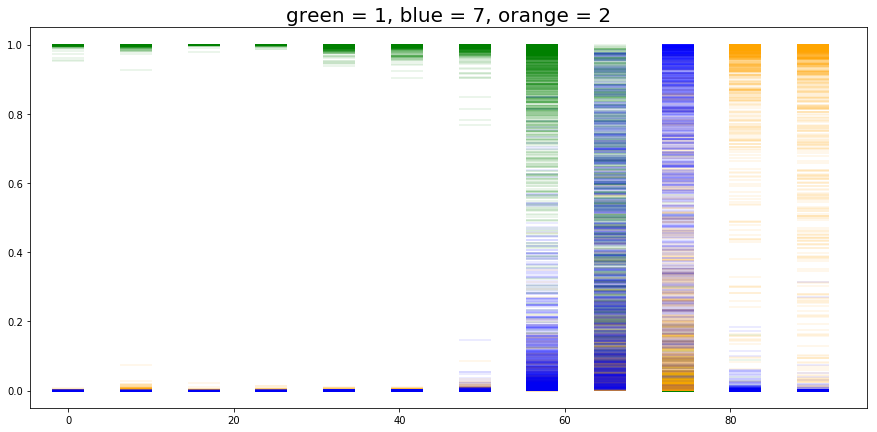

In [5]:
plt.figure(figsize=(15,7))

best_answers = data_probas.mean(axis=1).mean(axis=1).argsort()
color = {0: 'green', 1: 'orange', 2: 'blue'}
for i, angle in enumerate(angles):
    for j, number in enumerate(best_answers[-3::][::-1]):
        plt.scatter([angle] * SIZE, data_probas[number, i], alpha=0.1, c=color[j], marker='_', s=1000)
    
title = 'green = ' + str(best_answers[-1]) +\
        ', blue = ' + str(best_answers[-2]) +\
        ', orange = ' + str(best_answers[-3])     
plt.title(title, fontsize=20);

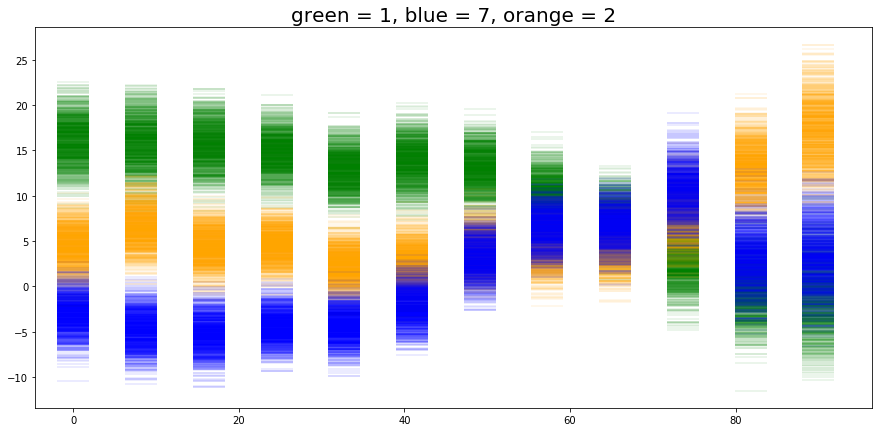

In [6]:
plt.figure(figsize=(15,7))

best_answers = data_probas.mean(axis=1).mean(axis=1).argsort()
color = {0: 'green', 1: 'orange', 2: 'blue'}
for i, angle in enumerate(angles):
    for j, number in enumerate(best_answers[-3::][::-1]):
        plt.scatter([angle] * SIZE, data_output[number, i], alpha=0.1, c=color[j], marker='_', s=1000)
    
title = 'green = ' + str(best_answers[-1]) +\
        ', blue = ' + str(best_answers[-2]) +\
        ', orange = ' + str(best_answers[-3])     
plt.title(title, fontsize=20);